In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from helper_function import DataGenerator
%matplotlib widget

In [2]:
data_uniform=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz",allow_pickle=True)
data_gauss=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)
data_gauss_5=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)

In [52]:
data_uniform=np.load(r"/Volumes/KINGSTON/Synthetic_data_no_defect/2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz",allow_pickle=True)
data_gauss=np.load(r"/Volumes/KINGSTON/Synthetic_data_no_defect/2025_10_24_sample_100x100x5mm_no_defect_isotropic_gaussian_heat.npz",allow_pickle=True)
data_gauss_5=np.load(r"/Volumes/KINGSTON/Synthetic_data_no_defect/2025_11_18_sample_100x100x5mm_no_defect_isotropic_gaussian_heat_no_conv_cond_5.npz",allow_pickle=True)

In [3]:
data_uniform['meta']

array([['time', '24/10/2025 20:16:11'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '300'],
       ['T2_units', 'frames'],
       ['T3', '3000'],
       ['T3_units', 'frames'],
       ['fps', '300.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '3304'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '2.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J

In [4]:
ccase=torch.from_numpy(data_uniform['data']).to(torch.float32)

In [5]:
operator=DataGenerator(ccase)

In [6]:
X,Y=operator.get_indexes_latin(80)
X_bd,Y_bd=operator.boundary_data(4)
X_bd_data,Y_bd_data=operator.network_format(X_bd,Y_bd)
X_data,Y_data=operator.network_format(X,Y,2)
X_init,Y_init=operator.set_initial_condition_points(20000)
time_axis,space_points=operator.set_collocation_points(10000,20000)

In [11]:
Y_init.size()

torch.Size([1])

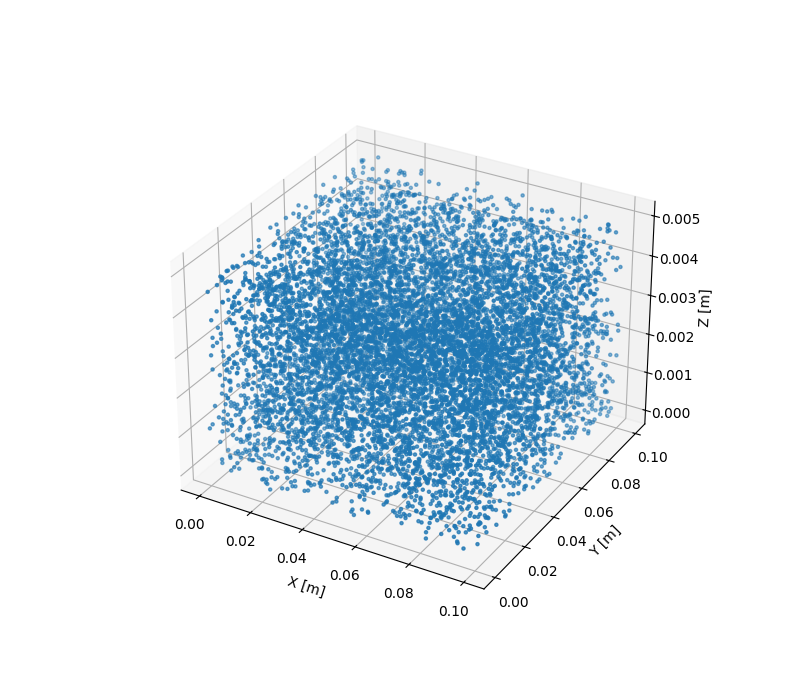

In [59]:
# exaggerate Z only for visualization

pts_viz = X_inital[:,1:] 

fig = plt.figure(figsize=(8,7))
plt.tight_layout()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pts_viz[:,0], pts_viz[:,1], pts_viz[:,2], s=5)

ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_zlabel("Z [m]")
plt.show()

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from helper_function import DataGenerator
from networks import ThermalDiffusionPINN
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# Physical scales of the problem 14 [s] 0.1 [m] width and height of the space domain and 0.005 [m] of the depth domain
phys_scales=torch.tensor([14.0,0.1,0.1,0.005]).to(torch.float32)

# data_uniform=np.load(r"C:\Users\stone\Desktop\Synthetic_data_no_defect\2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz",allow_pickle=True)
data_uniform=np.load(r"/Volumes/KINGSTON/Synthetic_data_no_defect/2025_10_24_sample_100x100x5mm_no_defect_isotropic.npz",allow_pickle=True)
ccase=torch.from_numpy(data_uniform['data']).to(torch.float32)

# Normalization of the temperature value
ccase=(ccase-ccase.min())/(ccase.max()-ccase.min())

operator=DataGenerator(ccase)

# Generate data
X,Y=operator.get_indexes_latin(80)
X_data,Y_data=operator.network_format(X,Y,2)

# Generate boundary data
X_bd,Y_bd=operator.boundary_data(4)
X_bd_data,Y_bd_data=operator.network_format(X_bd,Y_bd)

# Initial conditions of the points
X_init,Y_init=operator.set_initial_condition_points(20000)

# Collocation points
time_axis,space_points=operator.set_collocation_points(10000,20000)

# Normalization of the coordinate space

def normalize_coord(X,phys_scales):
    for i in range(4):
        X[:,i]=X[:,i]/phys_scales[i]
    return X

X_data_norm=normalize_coord(X_data,phys_scales)
X_bd_data_norm=normalize_coord(X_bd_data,phys_scales)
X_init_norm=normalize_coord(X_init,phys_scales)

time_axis=time_axis/phys_scales[0]
space_points[:,0]=space_points[:,0]/phys_scales[1]
space_points[:,1]=space_points[:,1]/phys_scales[2]
space_points[:,2]=space_points[:,2]/phys_scales[3]
